# The weights are fine tuned on subject classification

In [1]:
gpus = [1]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from scipy.spatial import distance
import seaborn as sns

In [3]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [4]:
morph_folder = os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli')

results_folder = os.path.abspath('/mnt/cube/kai/results/sound_texture/classifier')
spec_file = os.path.join(morph_folder, 'specs_star.p')

In [5]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [6]:
stim_cats = spec_df.stim.unique().tolist()

In [7]:
spec_list = spec_df.spec.values.tolist()

In [8]:
h, w = spec_list[0].shape

In [9]:
print(h, w)

298 76


## make model and load weights

In [17]:
clear_session()

In [18]:
model=self_VGG()

In [19]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
model_inputs = Input(shape=(h, w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
model_outputs = model(resized)
feature_extractor = Model(model_inputs, model_outputs)

In [21]:
weights_file = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/2021_07_14_21_46_52/subj_classification/unsegmented_trainable/weights-improvement.h5')
feature_extractor.load_weights(weights_file, by_name=True)

## extract feature vector from each morph

In [22]:
cat_list = []
id_list = []
feature_rmse_list = []
feature_cosine_list = []
spec_rmse_list = []

for cat in stim_cats:
    cat_specs = spec_df[spec_df.stim==cat].reset_index(drop=True)
    
    # init value
    init_spec = cat_specs[cat_specs.id==1].spec.values[0]
    init_spec_3d = np.stack([init_spec, init_spec, init_spec], axis = 2)
    init_features = np.squeeze(feature_extractor.predict(np.expand_dims(init_spec_3d, axis=0)))
    
    # iterate through morphs
    for _, spec_i, _, spec in cat_specs.values:
        spec_3d = np.stack([spec, spec, spec], axis = 2)

        spec_features = np.squeeze(feature_extractor.predict(np.expand_dims(spec_3d, axis=0)))
        
        cat_list.append(cat)
        id_list.append(spec_i)
        feature_rmse_list.append(rmse(init_features, spec_features))
        feature_cosine_list.append(distance.cosine(init_features, spec_features))
        spec_rmse_list.append(rmse(init_spec_3d, spec_3d))

    paragraph_print(f'Done with {cat}', separation='*')

Done with ac
**************************************************
Done with ad
**************************************************
Done with ae
**************************************************
Done with af
**************************************************
Done with ag
**************************************************
Done with ah
**************************************************
Done with bc
**************************************************
Done with bd
**************************************************
Done with be
**************************************************
Done with bf
**************************************************
Done with bg
**************************************************
Done with bh
**************************************************
Done with ce
**************************************************
Done with cf
**************************************************
Done with cg
**************************************************
Done with ch
***************************

In [24]:
morph_df = pd.DataFrame()
morph_df['morph_dim'] = cat_list
morph_df['id'] = id_list
morph_df['feature_rmse'] = feature_rmse_list
morph_df['feature_cosine'] = feature_cosine_list
morph_df['spec_rmse'] = spec_rmse_list

# inspect example morph dim

In [36]:
morph_dim = 'ae'

In [38]:
reduced_morph_df = morph_df[morph_df.morph_dim==morph_dim].reset_index(drop=True)

<AxesSubplot:xlabel='id', ylabel='spec_rmse'>

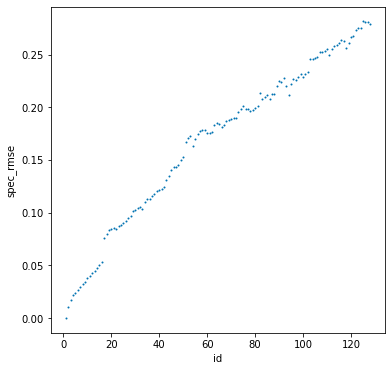

In [43]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(data=reduced_morph_df, x='id', y='spec_rmse', 
                s = 4, linewidth = 0)

<AxesSubplot:xlabel='id', ylabel='feature_rmse'>

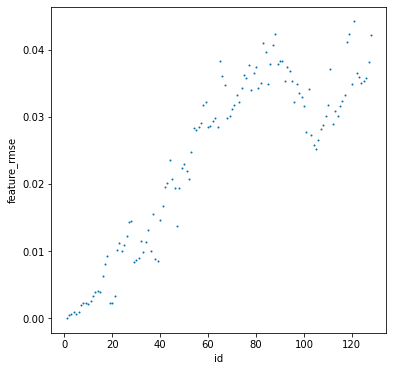

In [42]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(data=reduced_morph_df, x='id', y='feature_rmse', 
                s = 4, linewidth = 0)

# see all morph dims

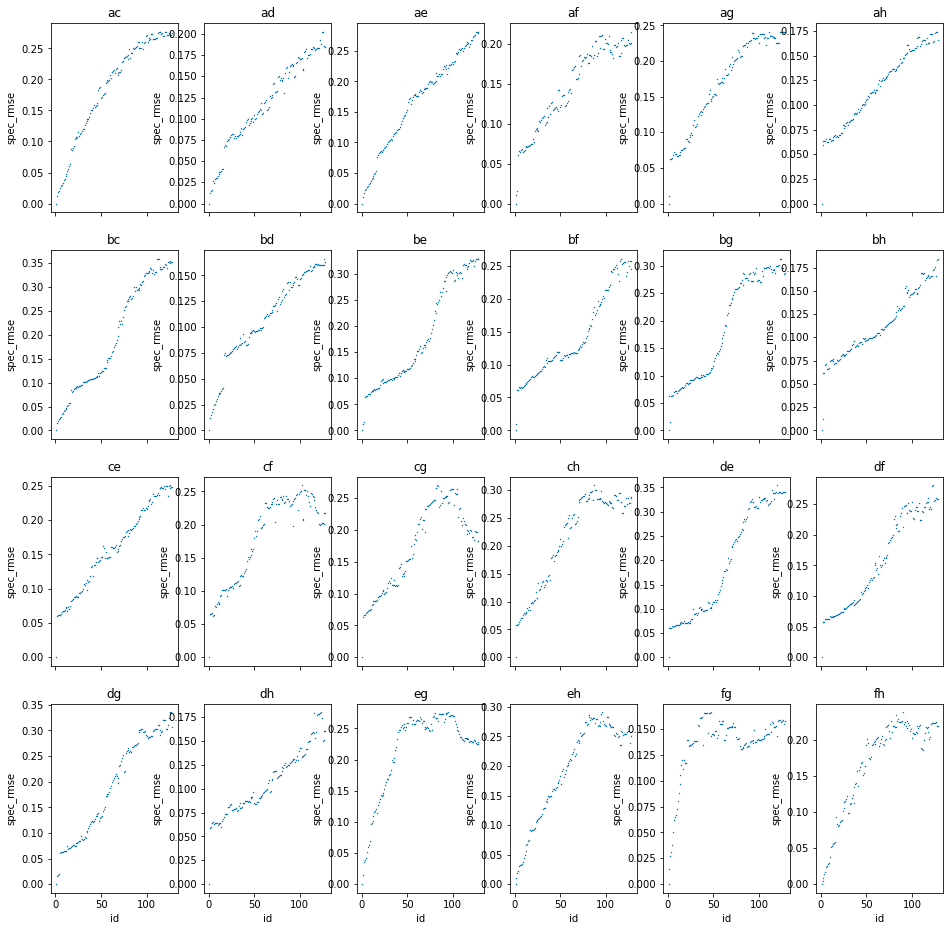

In [25]:
fig, ax = plt.subplots(4, 6, figsize=(16,16), sharex=True)
for i, morph_dim in enumerate(stim_cats):
    reduced_morph_df = morph_df[morph_df.morph_dim==morph_dim].reset_index(drop=True)
    row = i//6
    col = i%6
    sns.scatterplot(data=reduced_morph_df, x='id', y='spec_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)

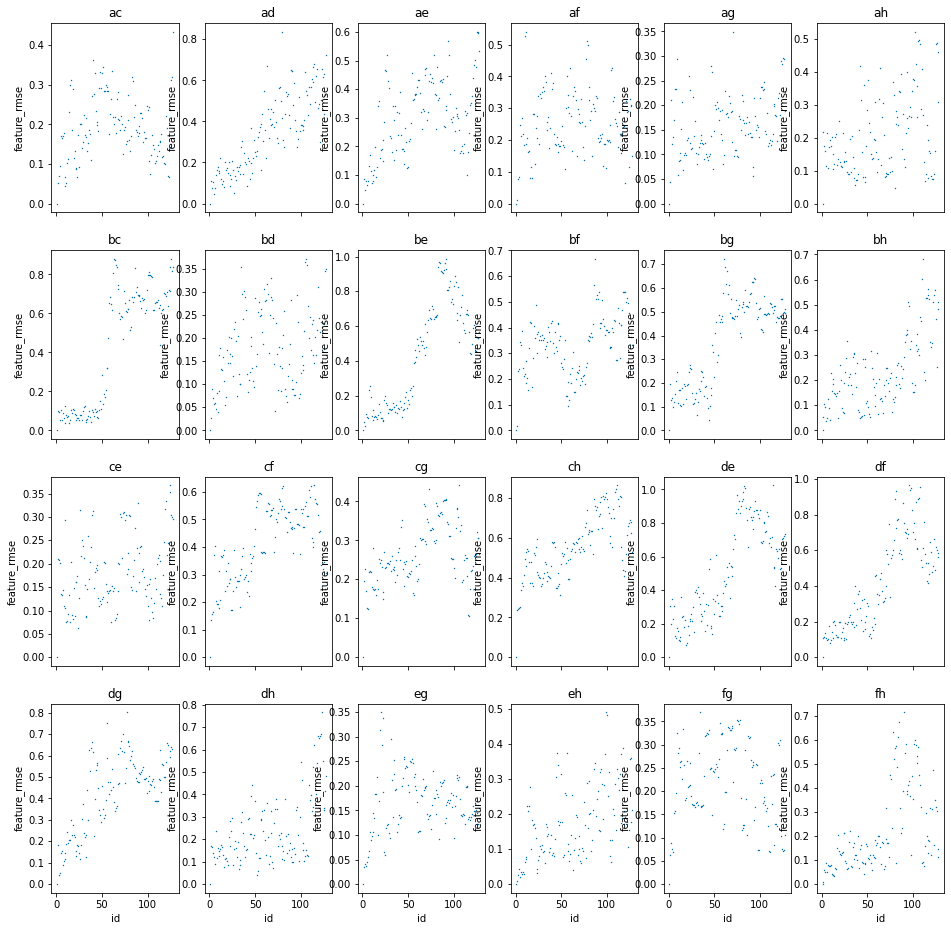

In [26]:
fig, ax = plt.subplots(4, 6, figsize=(16,16), sharex=True)
for i, morph_dim in enumerate(stim_cats):
    reduced_morph_df = morph_df[morph_df.morph_dim==morph_dim].reset_index(drop=True)
    row = i//6
    col = i%6
    sns.scatterplot(data=reduced_morph_df, x='id', y='feature_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)

In [27]:
row_dict = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5}
col_dict = {'c':0, 'd':1, 'e':2, 'f':3, 'g':4, 'h':5}

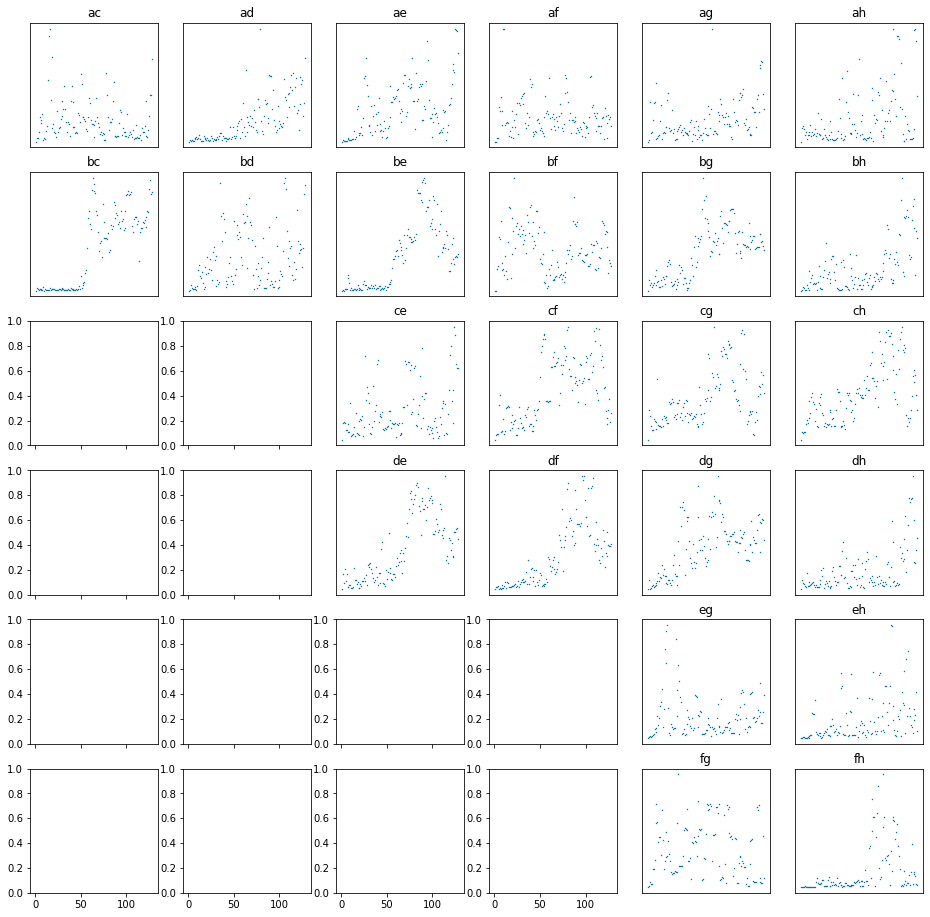

In [28]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for morph_dim in stim_cats:
    reduced_morph_df = morph_df[morph_df.morph_dim==morph_dim].reset_index(drop=True)
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='feature_cosine', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
    ax[row][col].get_yaxis().set_visible(False)


# if I make this symmetrical
define distance as the min between initial and final spec

In [29]:
cat_list = []
id_list = []
feature_rmse_list = []
feature_cosine_list = []
spec_rmse_list = []
less_dim_list = []
more_dim_list = []

for cat in stim_cats:
    cat_specs = spec_df[spec_df.stim==cat].reset_index(drop=True)
    
    # init value
    init_spec = cat_specs[cat_specs.id==1].spec.values[0]
    init_spec_3d = np.stack([init_spec, init_spec, init_spec], axis = 2)
    init_features = np.squeeze(feature_extractor.predict(np.expand_dims(init_spec_3d, axis=0)))
    
    # last value
    final_spec = cat_specs[cat_specs.id==128].spec.values[0]
    final_spec_3d = np.stack([final_spec, final_spec, final_spec], axis = 2)
    final_features = np.squeeze(feature_extractor.predict(np.expand_dims(final_spec_3d, axis=0)))
    
    # diff
    max_feature_rmse = rmse(init_features, final_features)
    max_feature_cosine = distance.cosine(init_features, final_features)
    max_spec_rmse = rmse(init_spec_3d, final_spec_3d)
    
    # iterate through morphs
    for _, spec_i, _, spec in cat_specs.values:
        spec_3d = np.stack([spec, spec, spec], axis = 2)

        spec_features = np.squeeze(feature_extractor.predict(np.expand_dims(spec_3d, axis=0)))
        
        init_feature_rmse = rmse(init_features, spec_features)
        final_feature_rmse = rmse(final_features, spec_features)
        init_feature_cosine = distance.cosine(init_features, spec_features)
        final_feature_cosine = distance.cosine(final_features, spec_features)
        init_spec_rmse = rmse(init_spec_3d, spec_3d)
        final_spec_rmse = rmse(final_spec_3d, spec_3d)
        
#         if init_feature_rmse>final_feature_rmse:
#             feature_rmse = max_feature_rmse-final_feature_rmse
#         else:
#             feature_rmse = init_feature_rmse
        
#         if init_feature_cosine>final_feature_cosine:
#             feature_cosine = max_feature_cosine-final_feature_cosine
#         else:
#             feature_cosine = init_feature_cosine
        
#         if init_spec_rmse>final_spec_rmse:
#             spec_rmse = max_spec_rmse-final_spec_rmse
#         else:
#             spec_rmse = init_spec_rmse
        
        feature_rmse = (max_feature_rmse-final_feature_rmse+init_feature_rmse)/2
        feature_cosine = (max_feature_cosine-final_feature_cosine+init_feature_cosine)/2
        spec_rmse = (max_spec_rmse-final_spec_rmse+init_spec_rmse)/2
        
        cat_list.append(cat)
        less_dim_list.append(cat[0])
        more_dim_list.append(cat[1])
        id_list.append(spec_i)
        
        feature_rmse_list.append(feature_rmse)
        feature_cosine_list.append(feature_cosine)
        spec_rmse_list.append(spec_rmse)

    paragraph_print(f'Done with {cat}', separation='*')

Done with ac
**************************************************
Done with ad
**************************************************
Done with ae
**************************************************
Done with af
**************************************************
Done with ag
**************************************************
Done with ah
**************************************************
Done with bc
**************************************************
Done with bd
**************************************************
Done with be
**************************************************
Done with bf
**************************************************
Done with bg
**************************************************
Done with bh
**************************************************
Done with ce
**************************************************
Done with cf
**************************************************
Done with cg
**************************************************
Done with ch
***************************

In [31]:
morph_df_sym = pd.DataFrame()
morph_df_sym['morph_dim'] = cat_list
morph_df_sym['id'] = id_list
morph_df_sym['lesser_dim'] = less_dim_list
morph_df_sym['greater_dim'] = more_dim_list
morph_df_sym['feature_rmse'] = feature_rmse_list
morph_df_sym['feature_cosine'] = feature_cosine_list
morph_df_sym['spec_rmse'] = spec_rmse_list

# see all morph dims

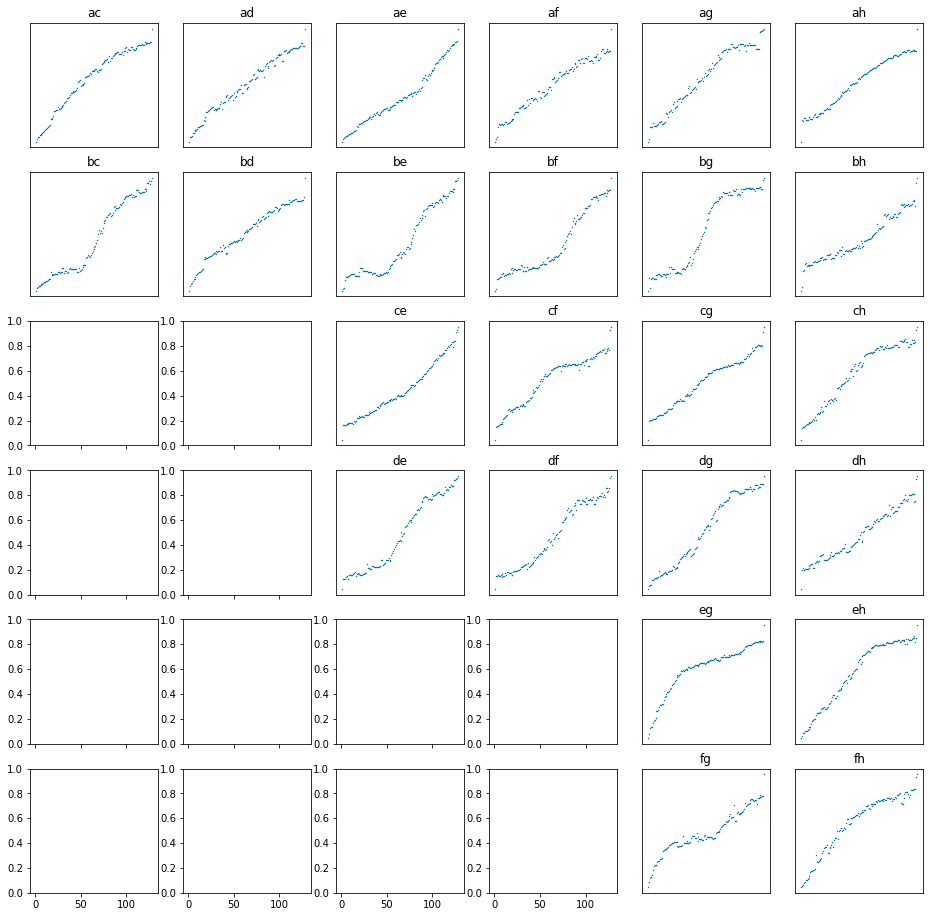

In [32]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for morph_dim in stim_cats:
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='spec_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
    ax[row][col].get_yaxis().set_visible(False)


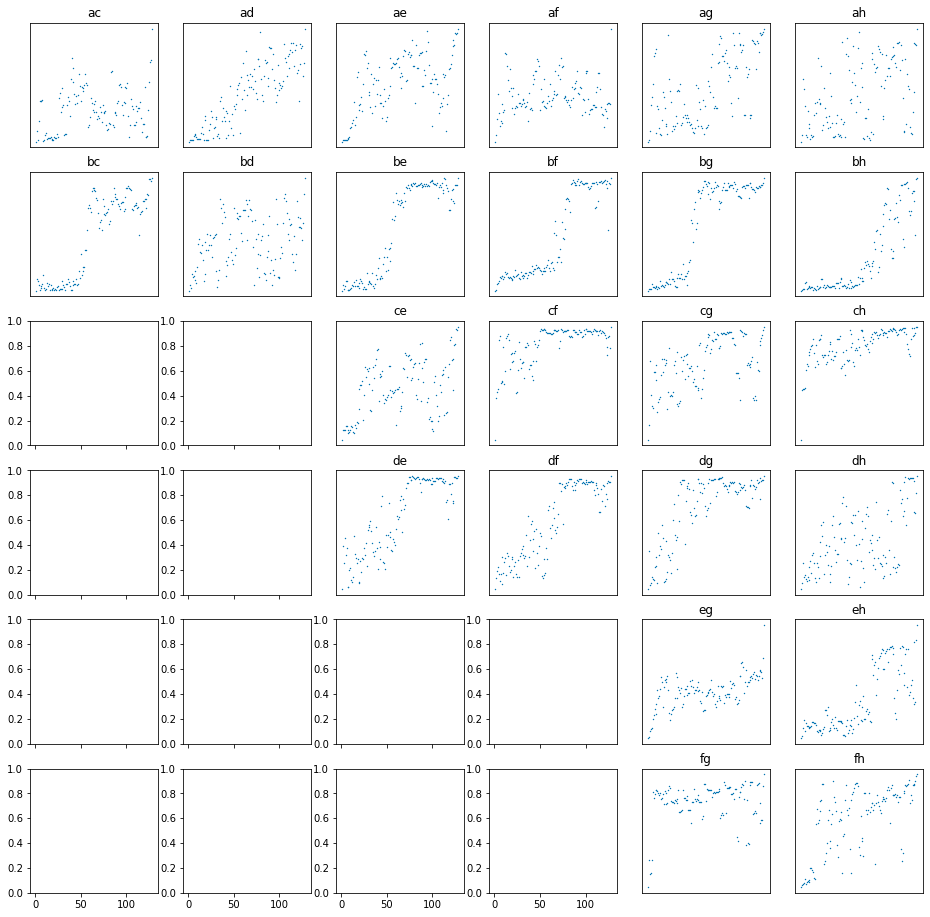

In [33]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for morph_dim in stim_cats:
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='feature_rmse', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
    ax[row][col].get_yaxis().set_visible(False)


In [34]:
row_dict = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5}
col_dict = {'c':0, 'd':1, 'e':2, 'f':3, 'g':4, 'h':5}

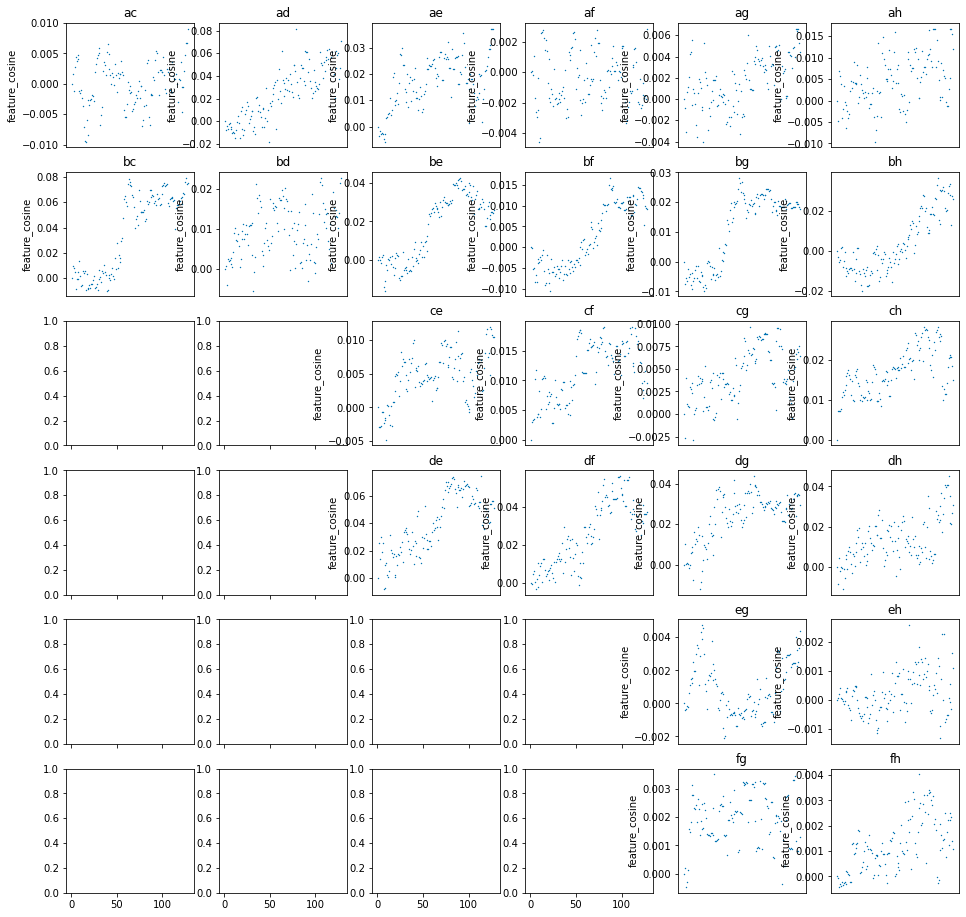

In [35]:
fig, ax = plt.subplots(6, 6, figsize=(16,16), sharex=True)
for morph_dim in stim_cats:
    reduced_morph_df = morph_df_sym[morph_df_sym.morph_dim==morph_dim].reset_index(drop=True)
    row = row_dict[morph_dim[0]]
    col = col_dict[morph_dim[1]]
    sns.scatterplot(data=reduced_morph_df, x='id', y='feature_cosine', 
                s = 2, linewidth = 0, ax=ax[row][col])
    ax[row][col].set_title(morph_dim)
    ax[row][col].get_xaxis().set_visible(False)
#     ax[row][col].get_yaxis().set_visible(False)


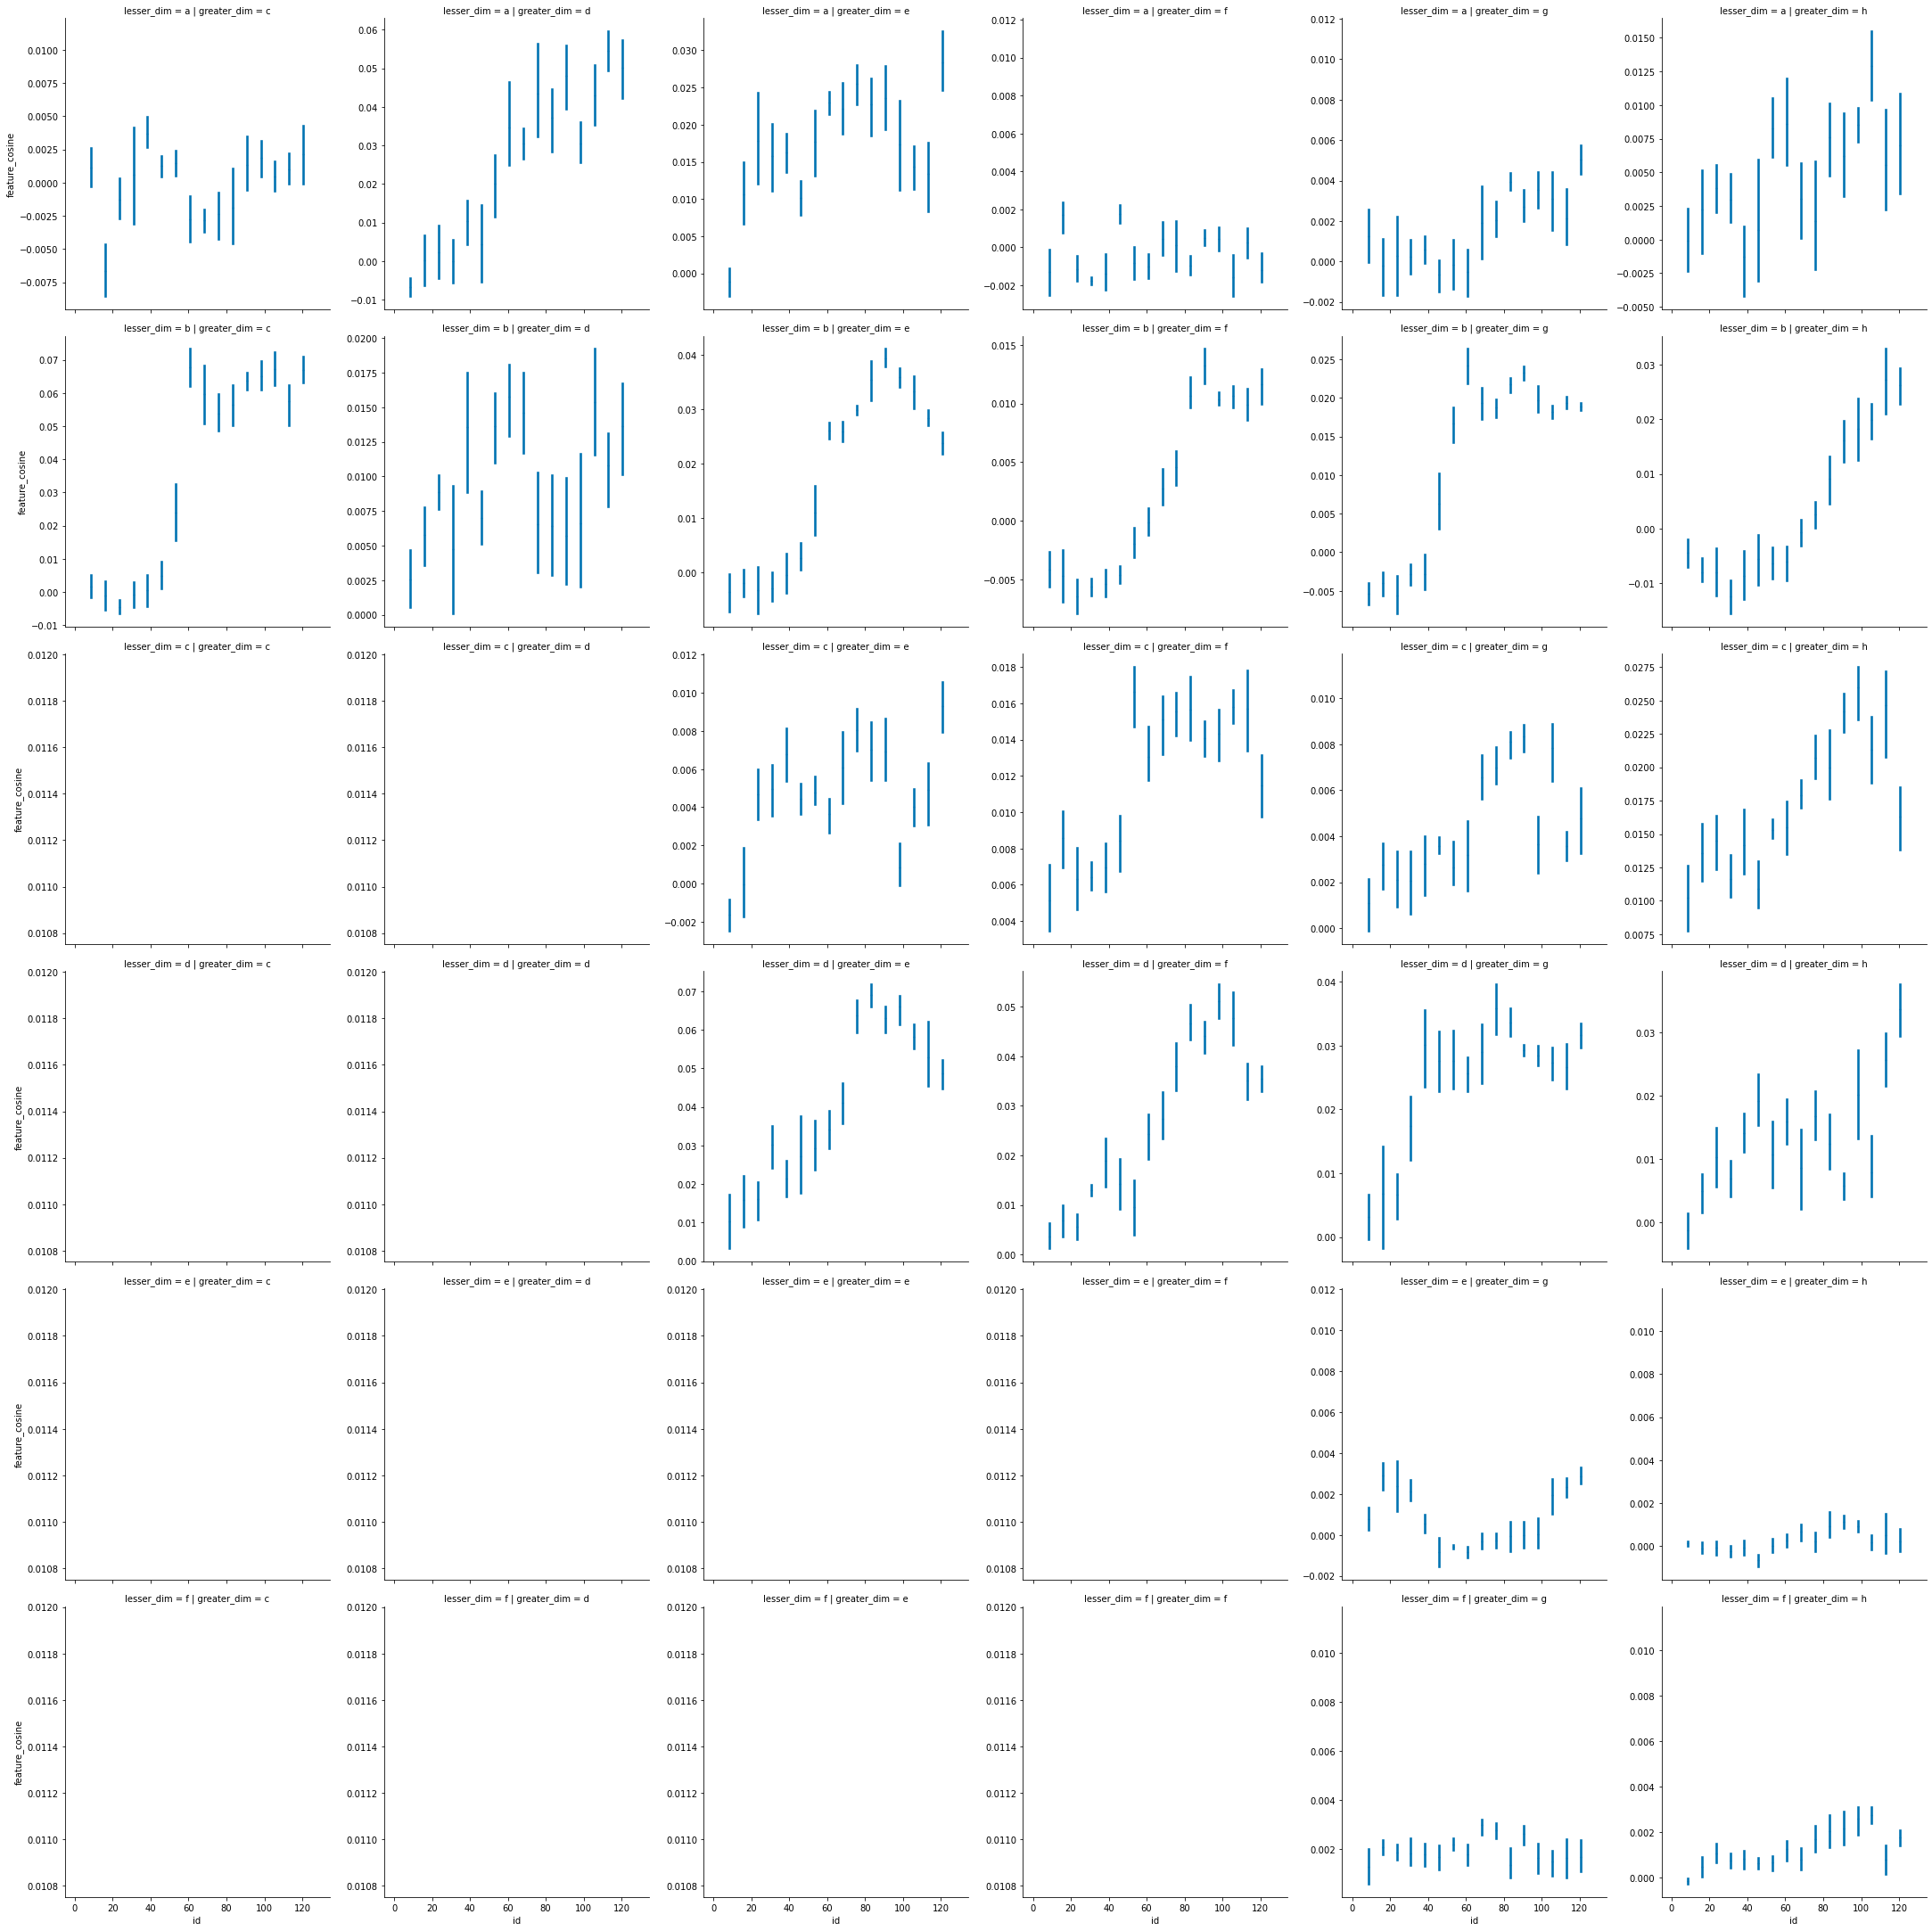

In [36]:
sns.lmplot(data=morph_df_sym, 
           x='id', 
           y='feature_cosine', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           x_bins=16, 
           scatter_kws={'s':1}, 
           fit_reg=False,
           sharey=False,
          legend=False)

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scal

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


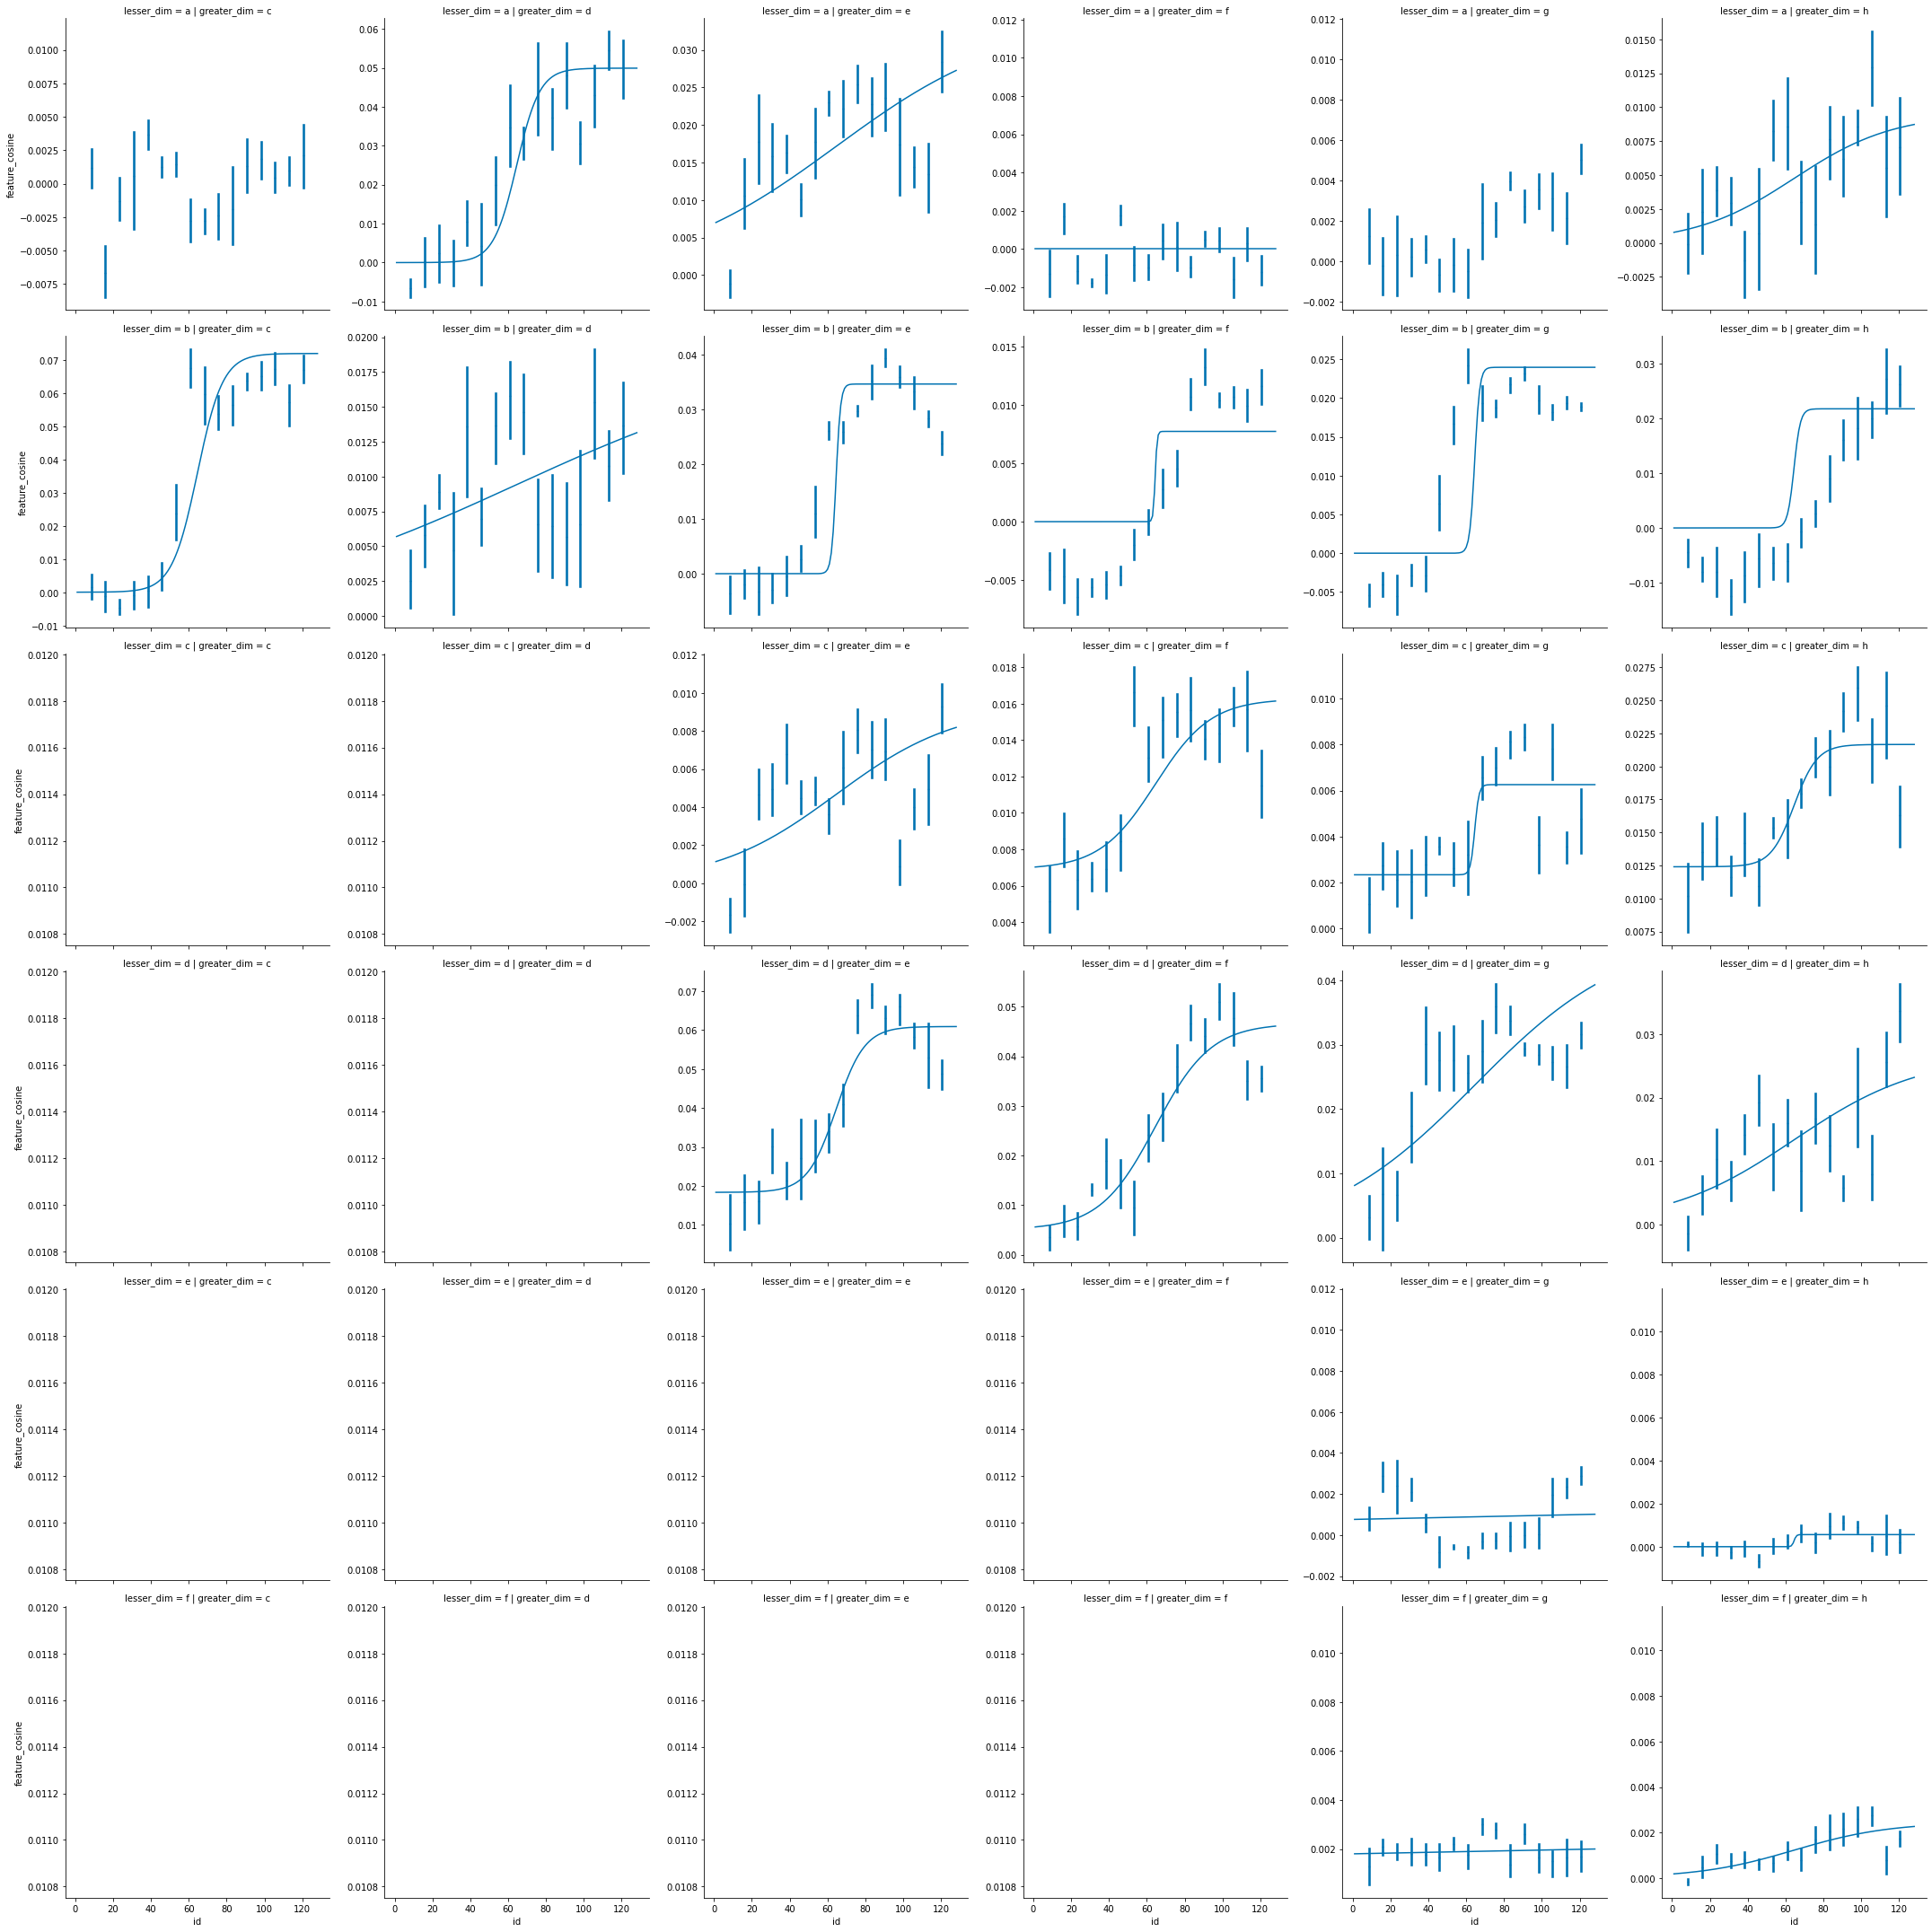

In [46]:
g = sns.lmplot(data=morph_df_sym, 
           x='id', 
           y='feature_cosine', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           x_bins=16, 
           scatter_kws={'s':1}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(_4pl, "id", "feature_cosine")

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scal

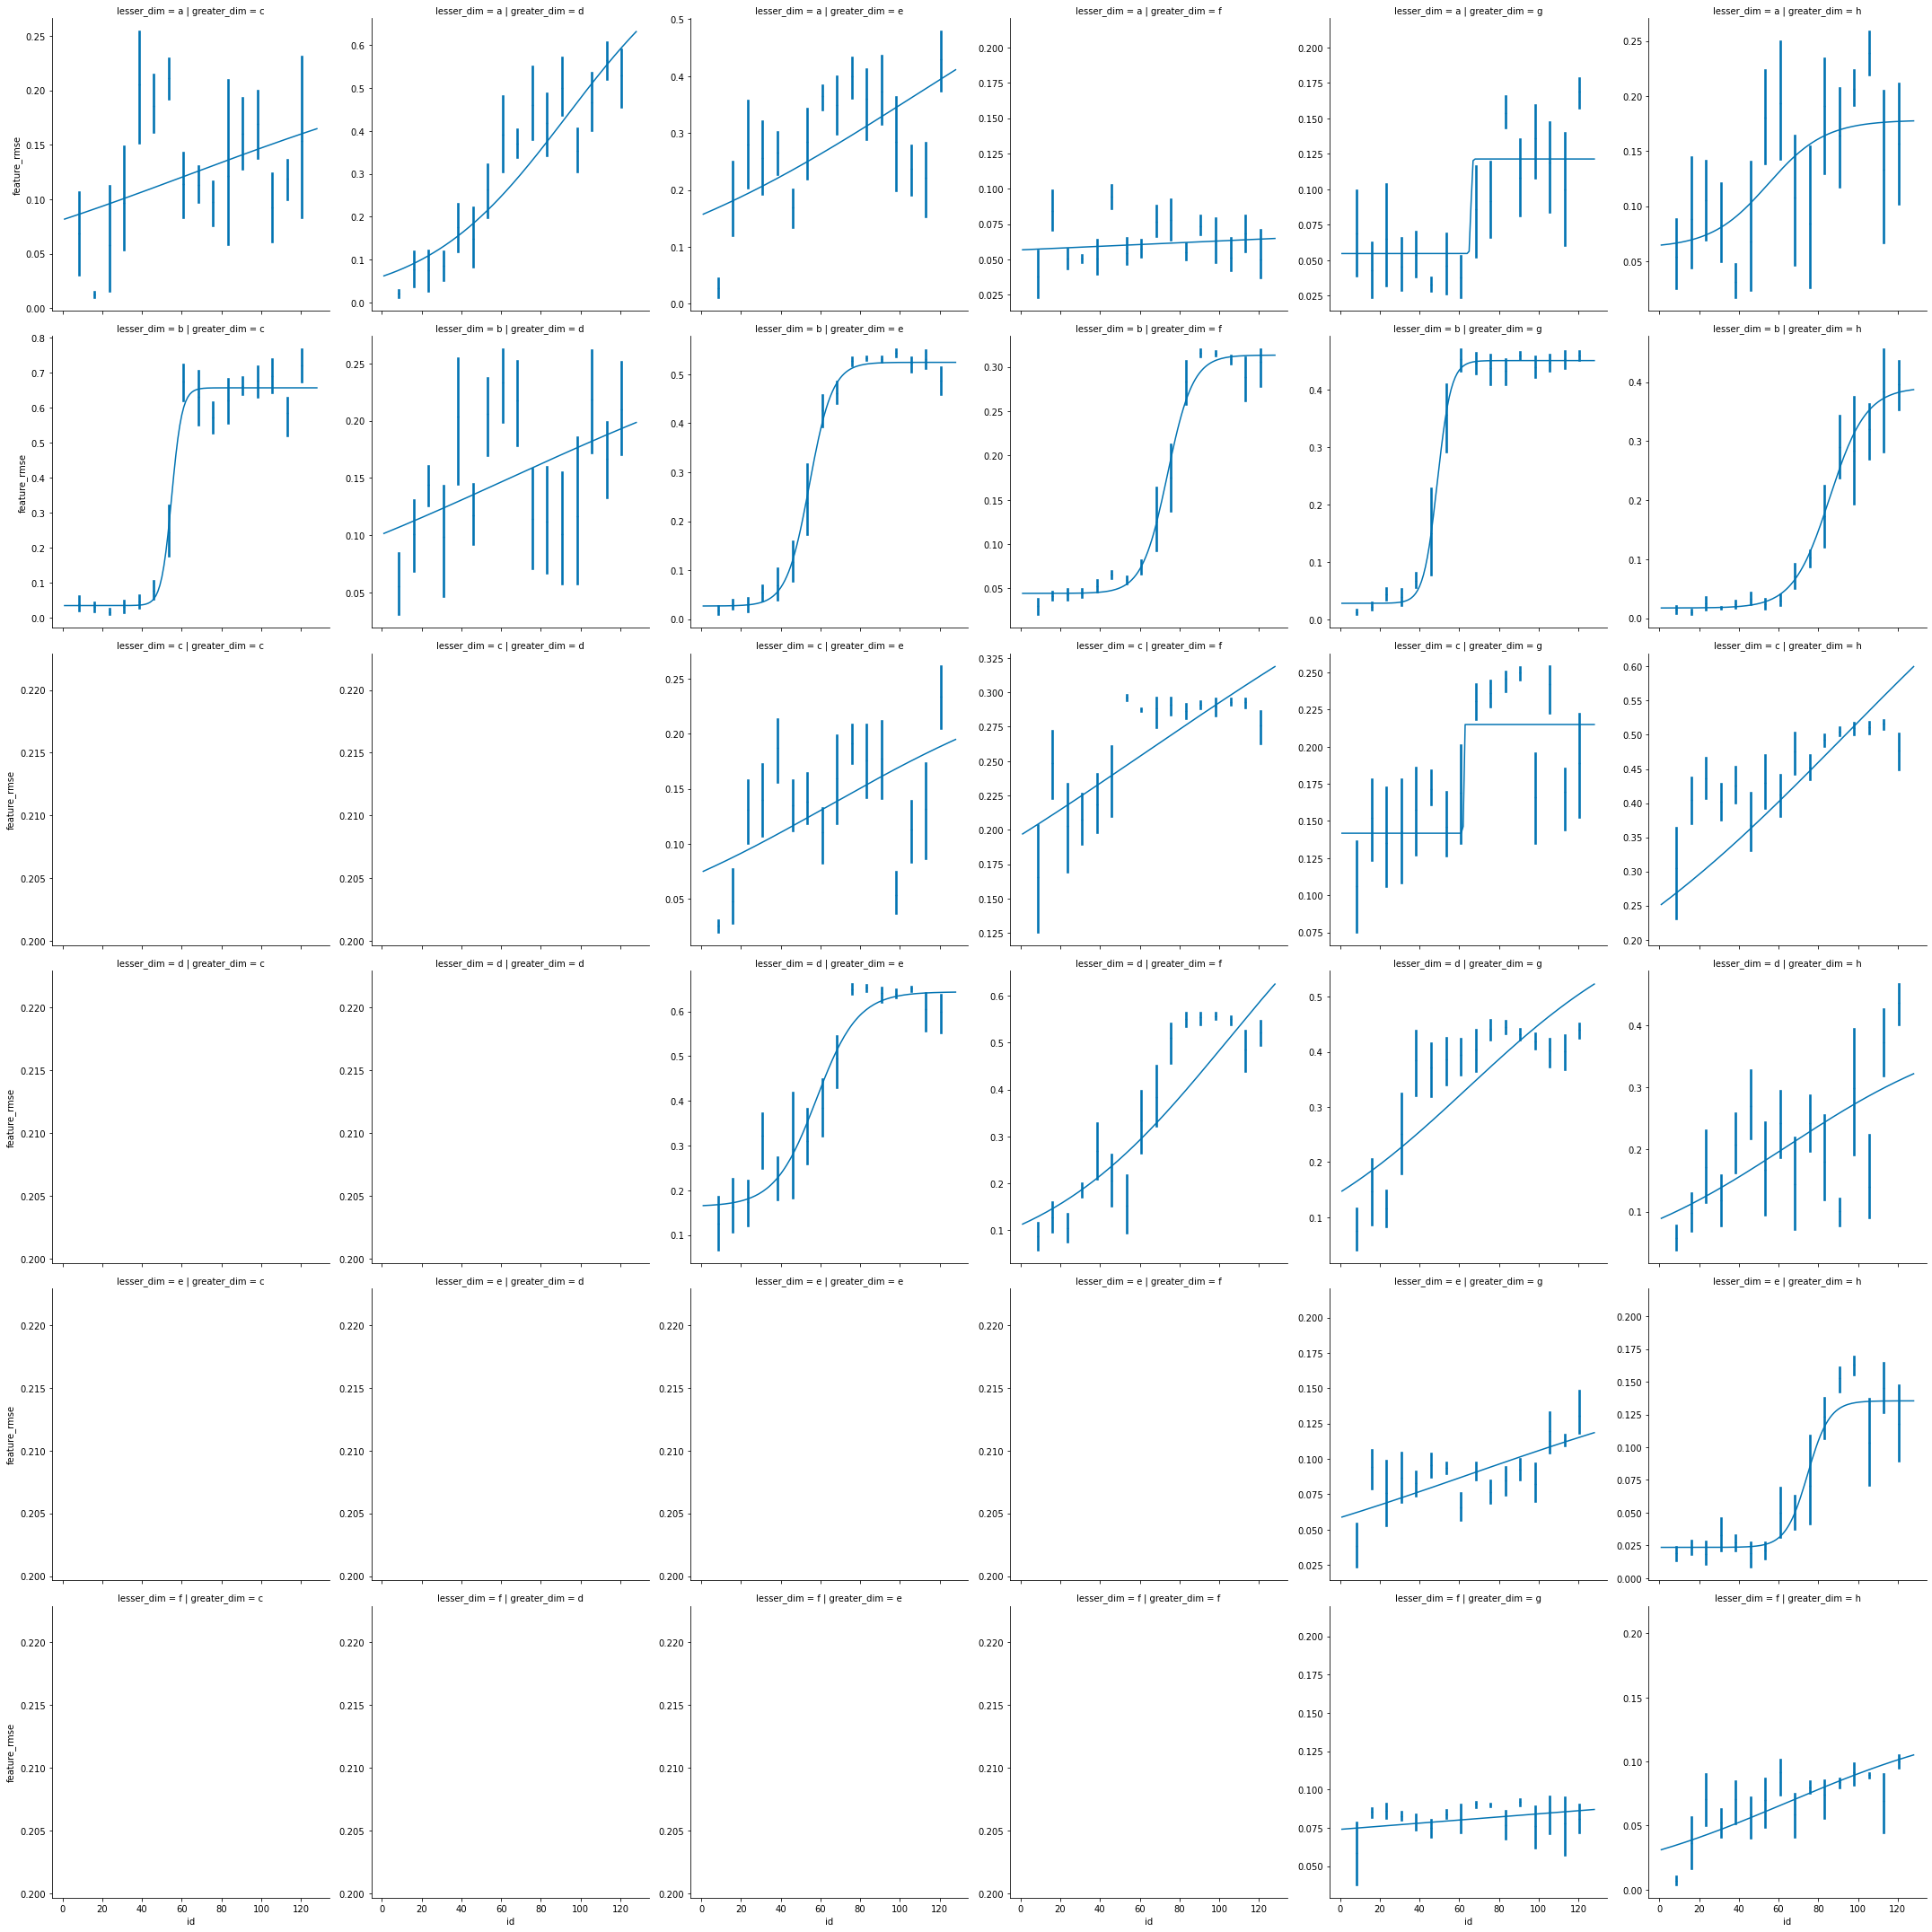

In [44]:
g = sns.lmplot(data=morph_df_sym, 
           x='id', 
           y='feature_rmse', 
           row='lesser_dim',
           col='greater_dim',
           row_order='abcdef',
           col_order='cdefgh',
           x_bins=16, 
           scatter_kws={'s':1}, 
           fit_reg=False,    
           sharey=False,
          legend=False)
g.map_dataframe(_4pl, "id", "feature_rmse")

In [38]:
def _4pl(x, y, color=None, **kwargs):
    data = kwargs.pop("data")

    result = fit_4pl(data[x].values, data[y].values.astype(np.double))
    try:
        result_4pl = four_param_logistic(result)
        t = np.arange(128) + 1

        if color is None:
            lines, = plt.plot(x.mean(), y.mean())
            color = lines.get_color()
            lines.remove()

        plt.plot(t, result_4pl(t), color=color)
    except TypeError:
        pass

In [39]:
import scipy.optimize as op

In [40]:
def fit_4pl(x, y, p_start=None, verbose=False, epsilon=1e-16):
    """Fits a 4 parameter logistic function to the data.

    Args:
        x: a numpy array of length n
            assumes a finite number of unique x values
        y: a numpy array of length n
            must be of dtype double or float so multiplication works
    optional:
        p_start: an iterable of length 4 that would be a reasonable spot to
            start the optimization. If None, tries to estimate it.
            A, K, B, M = p_start
            default=None
        verbose: boolean flag that allows printing of more error messages.
        epsilon: limits A and K between (epsilon, 1 - epsilon) for stability

    Returns:
        p_result: an iterable of length 4 that defines the model that
        is maximally likely
            A, K, B, M = p_result
    """
    try:
        if not p_start:
            p_start = est_pstart(x, y)
    except TypeError:
        pass
    for i in range(3):
        if verbose and i > 0:
            print("retry", i)
        result = op.minimize(
            nll,
            p_start,
            args=(x, y),
            jac=ndll,
            bounds=(
                (epsilon, 1 - epsilon),
                (epsilon, 1 - epsilon),
                (None, None),
                (None, None),
            ),
        )
        if result.success:
            return result.x
        else:
            if verbose:
                print(p_start, "failure", result)
            p_start = result.x
    return False

In [41]:
def four_param_logistic(p):
    """4p logistic function maker.

    Returns a function that accepts x and returns y for
    the 4-parameter logistic defined by p.

    The 4p logistic is defined by:
    y = A + (K - A) / (1 + exp(-B*(x-M)))

    Args:
        p: an iterable of length 4
            A, K, B, M = p

    Returns:
        A function that accepts a numpy array as an argument
        for x values and returns the y values for the defined 4pl curve.
    """
    A, K, B, M = p

    def f(x):
        return A + (K - A) / (1 + np.exp(-B * (x - M)))

    return f

In [42]:
def est_pstart(x, y):
    """basic estimation of a good place to start log likelihood maximization.

    Args:
        x: a numpy array of length n
            assumes a finite number of unique x values
        y: a numpy array of length n
            must be of dtype double or float so multiplication works

    Returns:
        p_start: an iterable of length 4 that should be a reasonable spot to
            start the optimization
            A, K, B, M = p_start
    """
    p_start = [0.01, 0.99, 0.2, 0]
    x_vals = np.unique(x)
    p_start[3] = np.mean(x_vals)
    y_est = np.array([np.mean(y[x == i]) for i in x_vals])
    midpoint_est = np.mean(np.where((y_est[0:-1] < 0.5) & (y_est[1:] >= 0.5)))
    if np.isnan(midpoint_est):
        return p_start
    p_start[3] = midpoint_est
    return p_start

In [43]:
def ln_like(p, x, y):
    """log likelihood for fitting the four parameter logistic.

    Args:
        p: an iterable of length 4
            A, K, B, M = p
        x: a numpy array of length n
        y: a numpy array of length n
            must be of dtype double or float so multiplication works

    Returns:
        The log-likelihood that the samples y are drawn from a distribution
        where the 4pl(x; p) is the probability of getting y=1
    """
    p_4pl = four_param_logistic(p)
    probs = p_4pl(x)
    return np.sum(y * np.log(probs) + (1 - y) * np.log(1 - probs))


def dln_like(p, x, y):
    """gradient of the log likelihood for fitting the four parameter logistic.

    Args:
        p: an iterable of length 4
            A, K, B, M = p
        x: a numpy array of length n
        y: a numpy array of length n
            must be of dtype double or float so multiplication works

    Returns:
        The gradient of the log-likelihood that the samples y are drawn from
        a distribution where the 4pl(x; p) is the probability of getting y=1
    """
    A, K, B, M = p

    def f(x):
        return A + (K - A) / (1 + np.exp(-B * (x - M)))

    def df(x):
        temp1 = np.exp(-B * (x - M))
        dK = 1.0 / (1.0 + temp1)
        dA = 1.0 - dK
        temp2 = temp1 / (1.0 + temp1) ** 2
        dB = (K - A) * (x - M) * temp2
        dM = -(K - A) * B * temp2
        return np.vstack((dA, dK, dB, dM))

    p_4pl = f(x)
    d_p_4pl = df(x)
    return np.sum(y * d_p_4pl / (p_4pl) - (1 - y) * d_p_4pl / (1 - p_4pl), 1)


def nll(*args):
    """negative log-likelihood for fitting the 4 param logistic."""
    return -ln_like(*args)


def ndll(*args):
    """negative grad of the log-likelihood for fitting the 4 param logistic."""
    return -dln_like(*args)